# Chapter 12 - Classification

- Apparently made famous by Bayesian spamn filters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empiricaldist import Cdf

df = pd.read_csv('data/penguins_raw.csv')
df.shape

(344, 17)

In [2]:
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


We'll use the following measurements when calssifying:
- Body mass (g)
- Flipper length (mm)
- Culmen length (mm)
- Culmen depth (mm)

(The culmen is the top bit of the beak)

In [3]:
def make_cdf_map(df, colname, by="Species"):
    """ Returns a dictionary indexed by the species name whose value is a cdf """
    cdf_map = dict()
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        cdf_map[species] = Cdf.from_seq(group, name=species)
    return cdf_map

culmen_length_cdf_map = make_cdf_map(df, "Culmen Length (mm)")

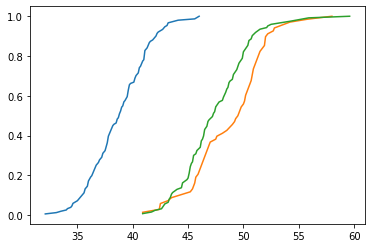

In [4]:
for cdf in culmen_length_cdf_map.values():
    cdf.plot()

Here, we can see that the Culmen Length is pretty good for identifying Adelie penguins, but not good for Chinstraps or Gentoos

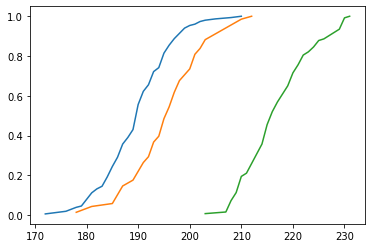

In [5]:
flipper_length_cdf_map = make_cdf_map(df, "Flipper Length (mm)")
for cdf in flipper_length_cdf_map.values():
    cdf.plot()

From the flipper length, we can distinguish Gentoos, but not the others!

But wait - that means that by combining the measurements of culmen depth and flipper length, we should be able to get a pretty good fix on what species a given individual belongs to!

## Normal Models

We'll use those features to try to classify the penguins. We'll proceed in the usual way:
1. Define a prior distribution with the three possible species and a prior probability for each
1. Compute the likelihood of the data for each hypothesis
1. Compute the posterior probability for each species

To compute the likelihood of the data for each species, we'll use the available data to estimate the parameters for a normal distribution for each species.

In [6]:
from scipy.stats import norm

def make_norm_map(df, colname, by="Species"):
    """ Creates a map whose keys are the species and whose values are the normal distribution approximating that attribute for that species"""
    norm_map = dict()
    grouped = df.groupby(by)[colname]
    for species, group in grouped:
        mean = group.mean()
        std = group.std()
        norm_map[species] = norm(mean, std)
    return norm_map

Now suppose we measure the flipper length of a penguin to be 193 cm. What is the probability of each measurement for each speciesm

In [7]:
flipper_map = make_norm_map(df, 'Flipper Length (mm)')

data = 193
hypos = flipper_map.keys()
hypos

dict_keys(['Adelie Penguin (Pygoscelis adeliae)', 'Chinstrap penguin (Pygoscelis antarctica)', 'Gentoo penguin (Pygoscelis papua)'])

In [8]:
likelihood = [ flipper_map[hypo].pdf(data) for hypo in hypos]
likelihood

[0.054732511875530694, 0.05172135615888162, 5.8660453661990634e-05]

## The Update

In [9]:
from empiricaldist import Pmf

prior = Pmf(1/3, hypos)
prior

,probs
Adelie Penguin (Pygoscelis adeliae),0.333333
Chinstrap penguin (Pygoscelis antarctica),0.333333
Gentoo penguin (Pygoscelis papua),0.333333


In [10]:
posterior = prior * likelihood
posterior.normalize()
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


So a penguin with a flipper that is 193mm long is about equally likeliy to be an Adelie of Chinstrap, but is unlikely to be a Gentoo

In [11]:
def update_penguin(prior, data, norm_map):
    """ Update the hypothetical species """
    hypos = prior.qs
    likelihood = [ norm_map[hypo].pdf(data) for hypo in hypos]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

# Here's our previous update using our new function
posterior1 = update_penguin(prior, 193, flipper_map)
posterior1

,probs
Adelie Penguin (Pygoscelis adeliae),0.513860
Chinstrap penguin (Pygoscelis antarctica),0.485589
Gentoo penguin (Pygoscelis papua),0.000551


As we saw, flipper length does not strongly distringuish Adelies and Chinstraps. However, the culmen length does, Let's see what we can find if we assume a Culmen length of 48mm:

In [12]:
culmen_map = make_norm_map(df, 'Culmen Length (mm)')
posterior2 = update_penguin(prior, 48, culmen_map)
posterior2

,probs
Adelie Penguin (Pygoscelis adeliae),0.001557
Chinstrap penguin (Pygoscelis antarctica),0.474658
Gentoo penguin (Pygoscelis papua),0.523785


Using one feature, it seems like we can rule out about one species at a time. Using multiple features, we can do better!

## Naive Bayesian Classification

Let's take a look at the following function, which can perform multiple updates:

In [13]:
def update_naive(prior, data_seq, norm_maps):
    """ 
    Performs a sequence of updates
    
    Arguments:
    prior: the prior probabilities
    data_seq: a sequence of data
    norm_maps: the normal maps to determine the likelihood of the data
    
    Returns: The updated classification
    """
    posterior = prior.copy()
    for data, norm_map in zip(data_seq, norm_maps):
        posterior = update_penguin(posterior, data, norm_map)
    return posterior

# Let's test it using the same features that we were looking at earlier
colnames = ['Flipper Length (mm)', 'Culmen Length (mm)']
norm_maps = [flipper_map, culmen_map]

# suppose we find a penguin with flipper length 193mm and culmen length 48mm:
data_seq = 193, 48
posterior = update_naive(prior, data_seq, norm_maps)
posterior

,probs
Adelie Penguin (Pygoscelis adeliae),0.003455
Chinstrap penguin (Pygoscelis antarctica),0.995299
Gentoo penguin (Pygoscelis papua),0.001246


What a success! By using two pieces of data, we are now 99.5\% sure that it is a Chinstrap!

We can test this idea by looping through the data and classifying each penguin based on these features.

In [14]:
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[colnames]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, "Classification"] = posterior.max_prob()
    
# Now let's see how many we get right!
valid = df['Classification'].notna()
valid.sum()

342

In [15]:
same = df['Species'] == df['Classification']
same.sum()

324

In [16]:
same.sum() / valid.sum()

0.9473684210526315

So this classifier, based on only two measurements, is about 95% correct!

The following function encapsulates the steps:

In [17]:
def accuracy(df):
    """ Compute the accuracy of classifications """
    valid = df['Classification'].notna()
    same = df['Classification'] == df['Species']
    return same.sum() / valid.sum()

## Joint Distributions

<AxesSubplot:xlabel='Flipper Length (mm)', ylabel='Culmen Length (mm)'>

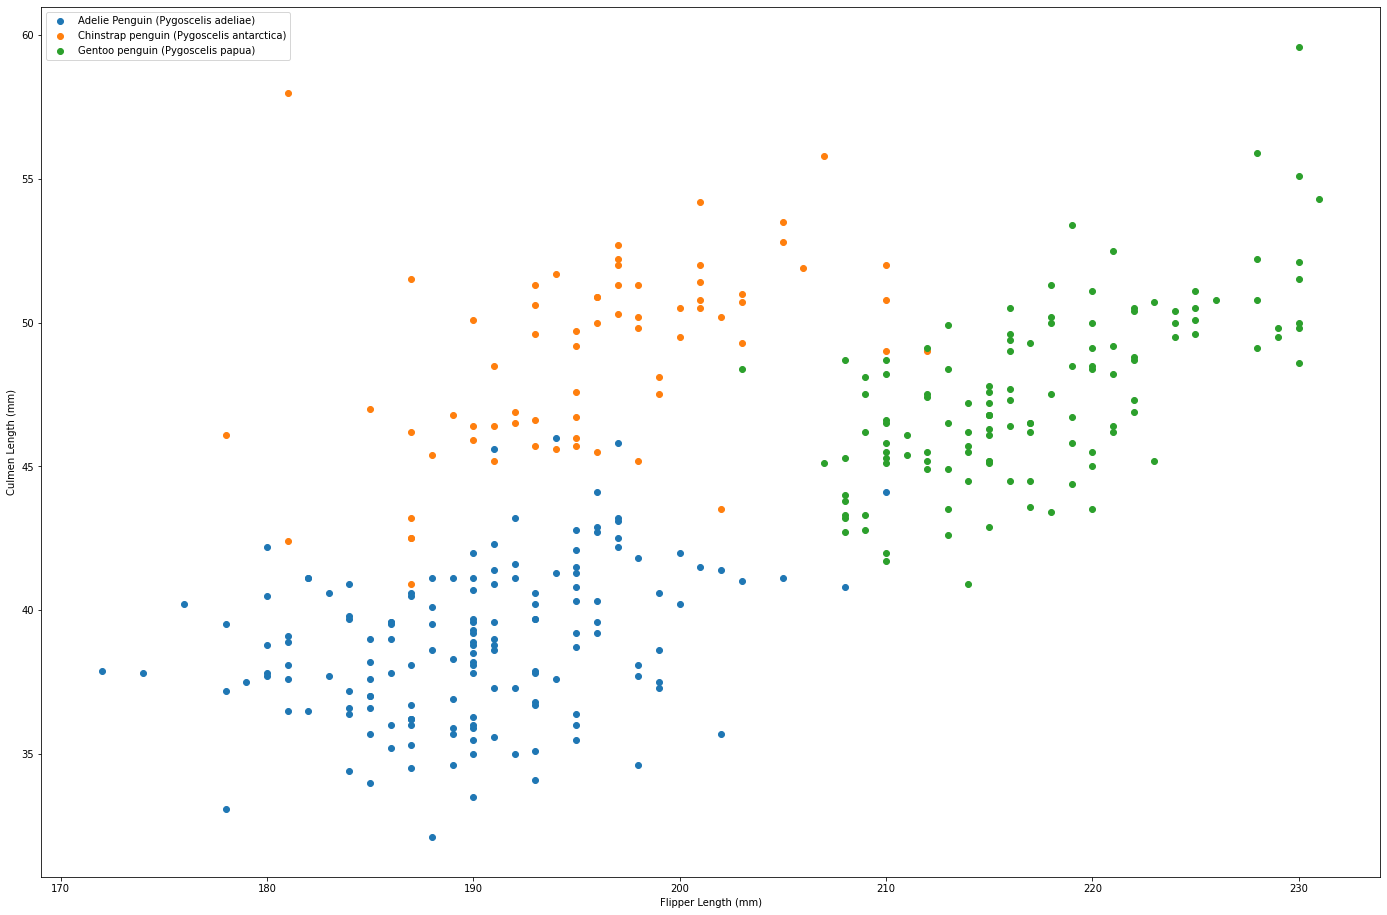

In [18]:
import matplotlib.pyplot as plt

def scatterplot(df, var1, var2):
    """ Make a scatterplot of the the columns var1 against var2 in the DataFrame """
    grouped = df.groupby('Species')
    fig, ax = plt.subplots()
    fig.set_size_inches(24, 16)
    for species, group in grouped:
        ax.scatter(group[var1], group[var2], label=species)
    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.legend()
    return ax
        
var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
scatterplot(df, var1, var2)

Within each species, the joint distribution of the measurements forms an oval (roughly). The orientation of the ovals is a diagonal, indicating the there is some correlation between the culmen length and flipper length.

If we ignore those correlations, we are assuming that the features are independent. To see what that looks like, I'll make a joint distribution for each species, assuming independence.

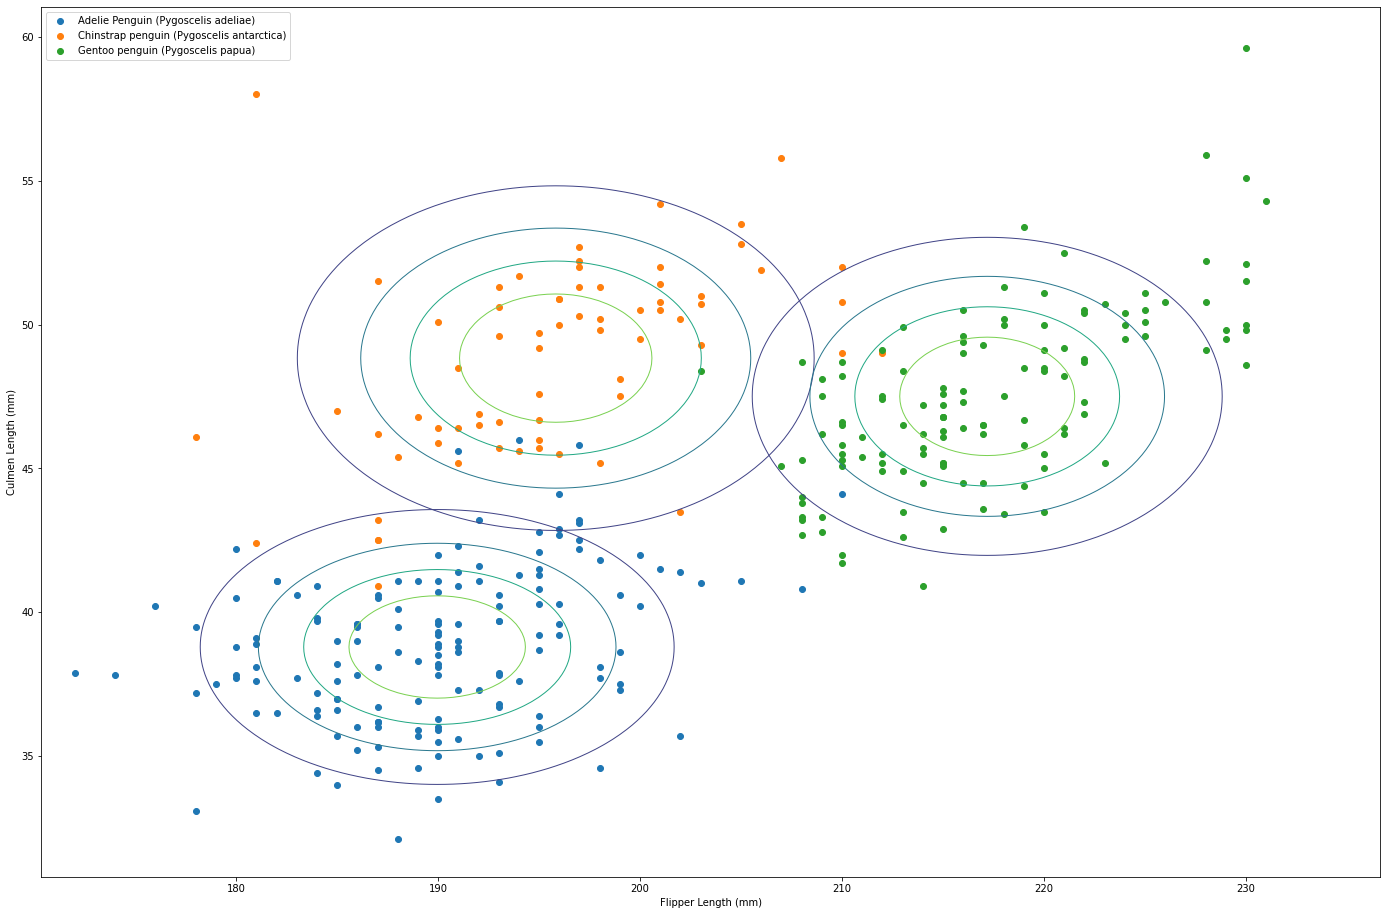

In [19]:
def make_pmf_norm(dist, sigmas=3, n=101):
    """ Make a Pmf approximation to the normal distribution """
    mean, std = dist.mean(), dist.std()
    low = mean - sigmas * std
    high = mean + sigmas * std
    qs = np.linspace(low, high, n)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

def make_joint(pmf1, pmf2):
    """ Make the joint distribution of pmf1 and 2, assuming independence """
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

joint_map = dict()
for species in hypos:
    pmf1 = make_pmf_norm(flipper_map[species])
    pmf2 = make_pmf_norm(culmen_map[species])
    joint_map[species] = make_joint(pmf1, pmf2)
    
    

var1 = 'Flipper Length (mm)'
var2 = 'Culmen Length (mm)'
ax = scatterplot(df, var1, var2)
for species in hypos:
    joint = joint_map[species]
    low = joint.to_numpy().min()
    high = joint.to_numpy().max()
    levels = np.linspace(low, high, 6)
    #levels = levels[1:]
    cs = plt.contour(joint.columns, joint.index, joint, levels=levels, linewidths=1)

Because we have treated them as independent, the axes of the ellipses are aligned parallel to the axes of the graph.

We can make this better by using the multivariate normal distribution!

## Multivariate Normal Distribution

The normal normal distribution is characterized by its mean and standard deviation. A multivariate normal distribution is characterized by the means of the features and the covariance matrix, which contains the variances and covariances of the features.

First we can use the data to estimate the means and covariances

In [20]:
features = df[[var1, var2]]
mean = features.mean()
mean

Flipper Length (mm)    200.915205
Culmen Length (mm)      43.921930
dtype: float64

In [21]:
cov = features.cov()
cov

,Flipper Length (mm),Culmen Length (mm)
Flipper Length (mm),197.731792,50.375765
Culmen Length (mm),50.375765,29.807054


In [22]:
from scipy.stats import multivariate_normal

# function to make a multivariate normal object for each species
def make_multivariate_normal(df, colnames):
    """ Make a map from each species to a multivariate normal """
    multinorm_map = {}
    grouped = df.groupby('Species')
    for species, group in grouped:
        features = group[colnames]
        mean = features.mean()
        cov = features.cov()
        multinorm_map[species] = multivariate_normal(mean, cov)
    return multinorm_map

multinorm_map = make_multivariate_normal(df, [var1, var2])
multinorm_map

{'Adelie Penguin (Pygoscelis adeliae)': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f77dcc5f910>,
 'Chinstrap penguin (Pygoscelis antarctica)': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f77dcc5f8e0>,
 'Gentoo penguin (Pygoscelis papua)': <scipy.stats._multivariate.multivariate_normal_frozen at 0x7f77dcc5fc10>}

(See the book - the ellipses are now aligned much better with the data and are no longer parallel to the axes)

Because the multivariate normal takes into account the correlations between the features, it should give much better classifications!

## A Less Naive Classifier

We can use the same `update_penguin` function that we used earlier, but now we can use the multivariate normal maps instead:

In [23]:
def update_penguin(prior, data, norm_map):
    hypos = prior.qs
    likelihood = [ norm_map[hypo].pdf(data) for hypo in hypos ]
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

data = 193, 48
update_penguin(prior, data, multinorm_map)

,probs
Adelie Penguin (Pygoscelis adeliae),0.002740
Chinstrap penguin (Pygoscelis antarctica),0.997257
Gentoo penguin (Pygoscelis papua),0.000003


So a penguin with these features is almost surely a Chinstrap!

Let's see if it does better than the naive classifier:

In [24]:
df['Classification'] = np.nan
for i, row in df.iterrows():
    data = row[colnames]
    posterior = update_penguin(prior, data, multinorm_map)
    df.loc[i, 'Classification'] = posterior.idxmax()
accuracy(df)

0.9532163742690059

So this is actually only slightly better: about 95.3% accurate against the 94.7% of the naive classifier.

## Exercises

### Exercise 12-1
> Previously we used flipper length and culmen length because they seemed to provide the most power to distinguish the penguins. Maybe we can do better by using more features? Make a naive Bayesian classifier that uses all four measurements in the dataset: culmen length, culmen depth, flipper length, and body mass. Is it more accurate than the model with two features?

### Solution 12-1

In [25]:
relevant_columns = [
    'Culmen Length (mm)',
    "Culmen Depth (mm)",
    'Flipper Length (mm)',
    "Body Mass (g)"
]
norm_maps = [ make_norm_map(df, column) for column in relevant_columns]
df['Classification'] = np.nan

for i, row in df.iterrows():
    data_seq = row[relevant_columns]
    posterior = update_naive(prior, data_seq, norm_maps)
    df.loc[i, 'Classification'] = posterior.max_prob()

accuracy(df)

0.9678362573099415

So by including all of these, we get only a slight bump to 96.7\%.

### Exercise 12-2
> One of the reasons that the penguin dataset was collected was to quantify sexual dimorphism in different penguin species; that is, how different are the males and females? One way to quantify sexual dimorphism is to use measurements to classify penguins by sex. If a species is more dimorphic, we expect to be able to classify them more accurately. 
>
> For this exercise, pick a species and use a Bayesian classifies (naive or not) to classify the penguins by sex. Which features are most useful? What accuracy can you achieve?

### Solution 12-2

In [26]:
df["Species"].value_counts()

Adelie Penguin (Pygoscelis adeliae)          152
Gentoo penguin (Pygoscelis papua)            124
Chinstrap penguin (Pygoscelis antarctica)     68
Name: Species, dtype: int64

In [27]:
is_gentoo = df['Species'] == 'Gentoo penguin (Pygoscelis papua)'
gentoo = df[is_gentoo]
gentoo = gentoo.copy()
gentoo.dropna(subset=["Sex"], inplace=True)
gentoo.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments,Classification
152,PAL0708,1,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N31A1,Yes,2007-11-27,46.1,13.2,211.0,4500.0,FEMALE,7.99300,-25.51390,NaN,Gentoo penguin (Pygoscelis papua)
153,PAL0708,2,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N31A2,Yes,2007-11-27,50.0,16.3,230.0,5700.0,MALE,8.14756,-25.39369,NaN,Gentoo penguin (Pygoscelis papua)
154,PAL0708,3,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A1,Yes,2007-11-27,48.7,14.1,210.0,4450.0,FEMALE,8.14705,-25.46172,NaN,Gentoo penguin (Pygoscelis papua)
155,PAL0708,4,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N32A2,Yes,2007-11-27,50.0,15.2,218.0,5700.0,MALE,8.25540,-25.40075,NaN,Gentoo penguin (Pygoscelis papua)
156,PAL0708,5,Gentoo penguin (Pygoscelis papua),Anvers,Biscoe,"Adult, 1 Egg Stage",N33A1,Yes,2007-11-18,47.6,14.5,215.0,5400.0,MALE,8.23450,-25.54456,NaN,Gentoo penguin (Pygoscelis papua)


In [28]:
gentoo['Sex'].value_counts()

MALE      61
FEMALE    58
Name: Sex, dtype: int64

In [29]:
gentoo['Sex'].unique()

array(['FEMALE', 'MALE'], dtype=object)

In [30]:
## Let's do it the naive way first
relevant_columns = [ "Culmen Length (mm)", "Culmen Depth (mm)", "Flipper Length (mm)", "Body Mass (g)"]
sex_prior = Pmf(1, gentoo['Sex'].unique())
sex_prior.normalize()
sex_prior

,probs
FEMALE,0.5
MALE,0.5


In [31]:
gentoo['Classification'] = np.nan

def flexible_accuracy(df, actual: str, guess: str):
    """
    Compare the accuracy of a classification 
    
    df: a dataframe
    actual: the column name holding the actual correct answer
    guess: column name holding the result produced by our classifier
    """
    valid = df[guess].notna()
    same = df[guess] == df[actual]
    return same.sum() / valid.sum()

norm_maps = [ make_norm_map(gentoo, column, by="Sex") for column in relevant_columns ]
norm_maps

[{'FEMALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaa670>,
  'MALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaa640>},
 {'FEMALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaac40>,
  'MALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaac10>},
 {'FEMALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaf1c0>,
  'MALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaf190>},
 {'FEMALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaf790>,
  'MALE': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f77dcbaf760>}]

In [32]:
for i, row in gentoo.iterrows():
    data_seq = row[relevant_columns]
    posterior = update_naive(sex_prior, data_seq, norm_maps)
    gentoo.loc[i, 'Classification'] = posterior.max_prob()
    
flexible_accuracy(gentoo, actual="Sex", guess="Classification")

0.9495798319327731